In [2]:
%load_ext autoreload

In [3]:
%autoreload 2

In [4]:
%cd ..

/Users/kristophermiltiadou/Documents/UniWork/Cambridge/Thesis/CODE/iREC


In [5]:
# load modules
import torch
import torch.distributions as dist
import pickle as pkl
import matplotlib.pyplot as plt
from models.BayesianLinRegressor import BayesLinRegressor
from rec.utils import compute_variational_posterior
import seaborn as sns; sns.set(); sns.set_style('whitegrid')
import math
plt.rcParams.update({'font.weight': 'normal'})
plt.rcParams.update({'font.size': 20})
plt.rcParams.update({'lines.linewidth' : 2})
%config InlineBackend.figure_format='retina'

In [6]:
%matplotlib inline

In [7]:
def create_blr_problem(dim, seed, signal_std=1):
    
    initial_seed_target = seed
    blr = BayesLinRegressor(prior_mean=torch.zeros(dim),
                        prior_alpha=1,
                        signal_std=signal_std,
                        num_targets=10000,
                        seed=initial_seed_target)
    blr.sample_feature_inputs()
    blr.sample_regression_targets()
    blr.posterior_update()
    target = blr.weight_posterior
    return blr, target

In [8]:
def compute_preds(d, blr_obj):
    preds = torch.zeros([0])
    sample_list = torch.tensor(d['compressed_samples'])
    for s in sample_list:
        preds = torch.cat((preds, blr_obj.empirical_prediction(s)[None]))
    return preds

In [9]:
def true_preds(blr_obj):
    samples = blr_obj.weight_posterior.sample((50,))
    preds = torch.zeros([0])
    for s in samples:
        preds = torch.cat((preds, blr_obj.empirical_prediction(s)[None]))
    return preds

In [10]:
def var_approx_preds(blr_obj):
    samples = compute_variational_posterior(blr_obj.weight_posterior).sample((50,))
    preds = torch.zeros([0])
    for s in samples:
        preds = torch.cat((preds, blr_obj.empirical_prediction(s)[None]))
    return preds

# Point Estimate Results

## MSE

In [65]:
epsilons = [0., 0.05, 0.1, 0.15, 0.2]
dim = 20
beamwidth = 5
emp = []
vari = []
hard = False
for eps in epsilons:
    vari.append(pkl.load(open(f"PickledStuff/New_Exp/Dim{dim}/Variational_Epsilon{eps}_Beam{beamwidth}_Omega5{'_HARD' if hard else ''}.pkl", "rb")))
    emp.append(pkl.load(open(f"PickledStuff/New_Exp/Dim{dim}/Empirical_Epsilon{eps}_Beam{beamwidth}_Omega5{'_HARD' if hard else ''}.pkl", "rb")))

In [58]:
blr_seed = 1
signal_std = 1e-1 if hard else 1
b, t = create_blr_problem(dim=dim, seed=blr_seed, signal_std=signal_std)

In [59]:
vari_full_preds = torch.zeros(len(epsilons), 50, len(b.regression_targets_test))
emp_full_preds = torch.zeros(len(epsilons), 50, len(b.regression_targets_test))
for i, _ in enumerate(epsilons):
    emp_full_preds[i] = compute_preds(emp[i], b)
    vari_full_preds[i] = compute_preds(vari[i], b)

In [60]:
q = torch.tensor([0.25, 0.5, 0.75])
emp_median_rmse = torch.quantile(torch.sqrt(torch.mean((emp_full_preds - b.regression_targets_test) ** 2, dim=2)), q, dim=1)
emp_median_mae = torch.quantile(torch.mean(torch.abs(emp_full_preds - b.regression_targets_test), dim=2), q, dim=1)

var_median_rmse = torch.quantile(torch.sqrt(torch.mean((vari_full_preds - b.regression_targets_test) ** 2, dim=2)), q, dim=1)
var_median_mae = torch.quantile(torch.mean(torch.abs(vari_full_preds - b.regression_targets_test), dim=2), q, dim=1)

In [61]:
mean_rmse_map = torch.sqrt(torch.mean((b.empirical_prediction(t.mean) - b.regression_targets_test) ** 2))

mean_mae_map = torch.mean(torch.abs(b.empirical_prediction(t.mean) - b.regression_targets_test))

In [62]:
def percentage_dropoff(stat, exact_stat, neg=False):
    if neg:
        diff = stat - exact_stat
        return 100 + (diff / exact_stat) * 100
    else:
        diff = stat - exact_stat
        return 100 - (diff / exact_stat) * 100

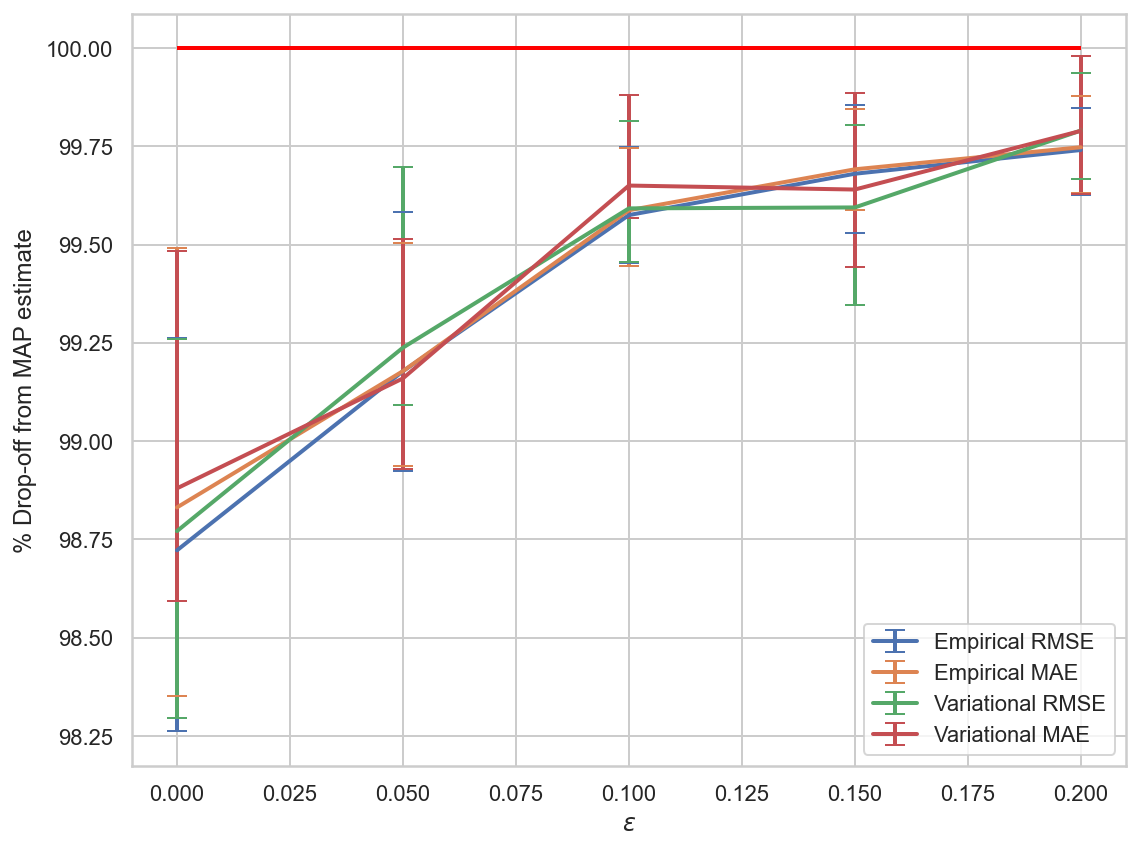

In [63]:
fig, ax = plt.subplots(1, figsize=(8,6))
ax.errorbar(epsilons, percentage_dropoff(emp_median_rmse, mean_rmse_map)[1], capsize=5, 
            yerr= torch.abs(percentage_dropoff(emp_median_rmse, mean_rmse_map) - percentage_dropoff(emp_median_rmse, mean_rmse_map)[1])[[0, -1]], label='Empirical RMSE')
ax.errorbar(epsilons, percentage_dropoff(emp_median_mae, mean_mae_map)[1], capsize=5,
            yerr= torch.abs(percentage_dropoff(emp_median_mae, mean_mae_map) - percentage_dropoff(emp_median_mae, mean_mae_map)[1])[[0, -1]], label='Empirical MAE')
ax.errorbar(epsilons, percentage_dropoff(var_median_rmse, mean_rmse_map)[1], capsize=5, 
            yerr= torch.abs(percentage_dropoff(var_median_rmse, mean_rmse_map) - percentage_dropoff(var_median_rmse, mean_rmse_map)[1])[[0, -1]], label='Variational RMSE')
ax.errorbar(epsilons, percentage_dropoff(var_median_mae, mean_mae_map)[1], capsize=5,
            yerr= torch.abs(percentage_dropoff(var_median_mae, mean_mae_map) - percentage_dropoff(var_median_mae, mean_mae_map)[1])[[0, -1]], label='Variational MAE')
ax.hlines(100, xmin=epsilons[0], xmax=epsilons[-1], color='red')
ax.set_xlabel(r'$\epsilon$')
ax.set_ylabel('% Drop-off from MAP estimate')
ax.legend(loc='lower right')
fig.tight_layout()
#fig.savefig(f"Figures/RMSE_MAE/Dim{dim}_Beamwidth{beamwidth}.jpg", dpi=250, bbox_inches='tight')

## Log-likelihood

In [41]:
emp_log_likelihood_per_sample = torch.quantile(torch.sum(dist.normal.Normal(loc=emp_full_preds, scale=signal_std).log_prob(b.regression_targets_test), dim=2), q, dim=1)

var_log_likelihood_per_sample = torch.quantile(torch.sum(dist.normal.Normal(loc=vari_full_preds, scale=signal_std).log_prob(b.regression_targets_test), dim=2), q, dim=1)

In [42]:
map_log_likelihood = torch.sum(dist.normal.Normal(loc=b.empirical_prediction(t.mean), scale=signal_std).log_prob(b.regression_targets_test))

In [43]:
torch.sum(dist.normal.Normal(loc=b.empirical_prediction(b.true_sample), scale=1).log_prob(b.regression_targets_test))

tensor(-3510.7910)

In [44]:
map_log_likelihood

tensor(-3517.5186)

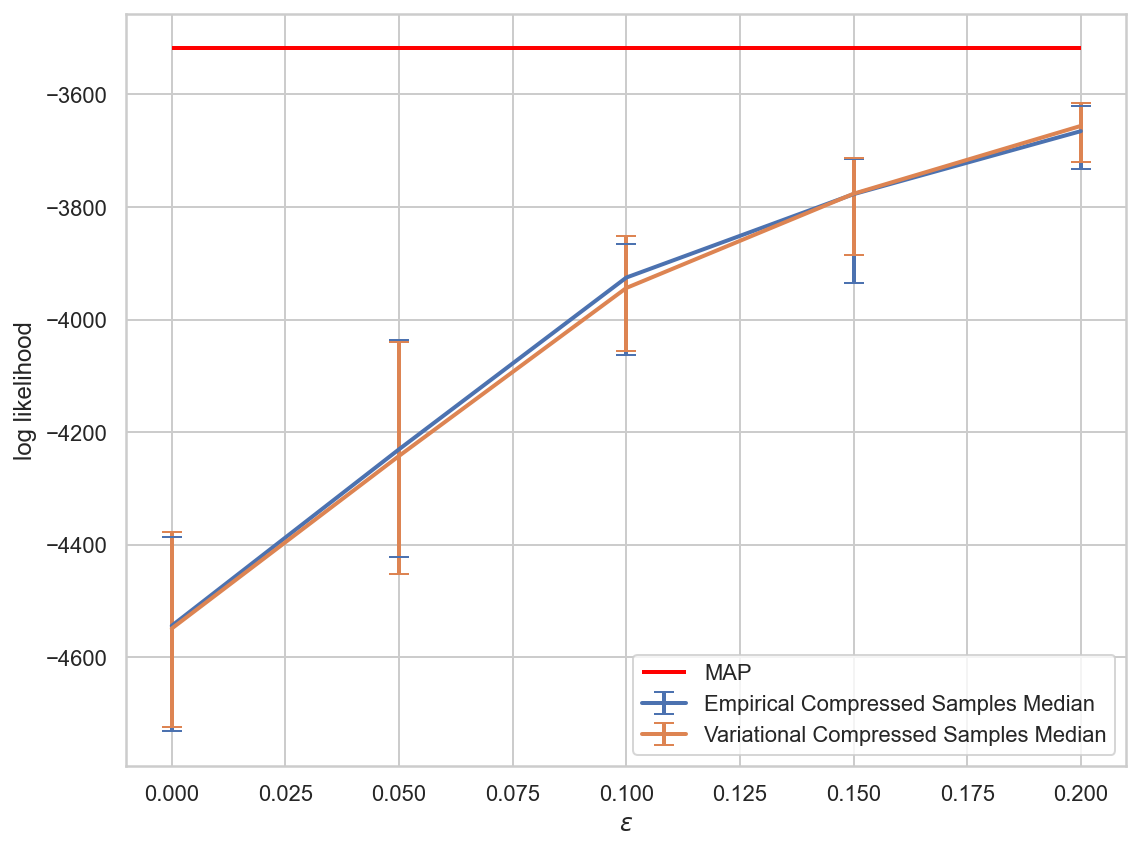

In [45]:
fig, ax = plt.subplots(1, figsize=(8,6))
ax.errorbar(epsilons, emp_log_likelihood_per_sample[1], capsize=5, 
            yerr = torch.abs(emp_log_likelihood_per_sample - emp_log_likelihood_per_sample[1])[[0, -1]], label='Empirical Compressed Samples Median')
ax.errorbar(epsilons, var_log_likelihood_per_sample[1], capsize=5, 
            yerr = torch.abs(var_log_likelihood_per_sample - var_log_likelihood_per_sample[1])[[0, -1]], label='Variational Compressed Samples Median')
ax.hlines(map_log_likelihood, xmin=epsilons[0], xmax=epsilons[-1], color='red', label='MAP')
ax.set_xlabel(r'$\epsilon$')
ax.set_ylabel('log likelihood')
ax.legend(loc='lower right')
fig.tight_layout()
#fig.savefig(f"Figures/MAP_LIKELIHOOD/Dim{dim}_Beamwidth{beamwidth}.jpg", dpi=250, bbox_inches='tight')

# Considering Ensembles

## Log-likelihood

In [46]:
emp_ensemble_preds = torch.mean(emp_full_preds, dim=1)

emp_ensemble_log_likelihood = torch.sum(dist.normal.Normal(loc=emp_ensemble_preds, scale=signal_std).log_prob(b.regression_targets_test), dim=1)

var_ensemble_preds = torch.mean(vari_full_preds, dim=1)

var_ensemble_log_likelihood = torch.sum(dist.normal.Normal(loc=var_ensemble_preds, scale=signal_std).log_prob(b.regression_targets_test), dim=1)

In [47]:
exact_ensemble = torch.mean(true_preds(b), dim=0)

In [48]:
exact_ensemble_likelihood = torch.sum(dist.normal.Normal(loc=exact_ensemble, scale=signal_std).log_prob(b.regression_targets_test))

In [49]:
exact_ensemble_var = torch.mean(var_approx_preds(b), dim=0)

In [50]:
exact_ensemble_likelihood_var = torch.sum(dist.normal.Normal(loc=exact_ensemble_var, scale=signal_std).log_prob(b.regression_targets_test))

In [51]:
full_predictive_mu, full_predictive_var = b.predictive_distribution(b.feature_targets_test)

In [52]:
full_predictive_dist = dist.normal.Normal(loc=full_predictive_mu, scale=torch.pow(full_predictive_var, 0.5))

In [53]:
full_likelihood = torch.sum(full_predictive_dist.log_prob(b.regression_targets_test))

In [54]:
full_likelihood

tensor(-3517.6887)

In [55]:
exact_ensemble_likelihood, exact_ensemble_likelihood_var

(tensor(-3517.6272), tensor(-3517.9414))

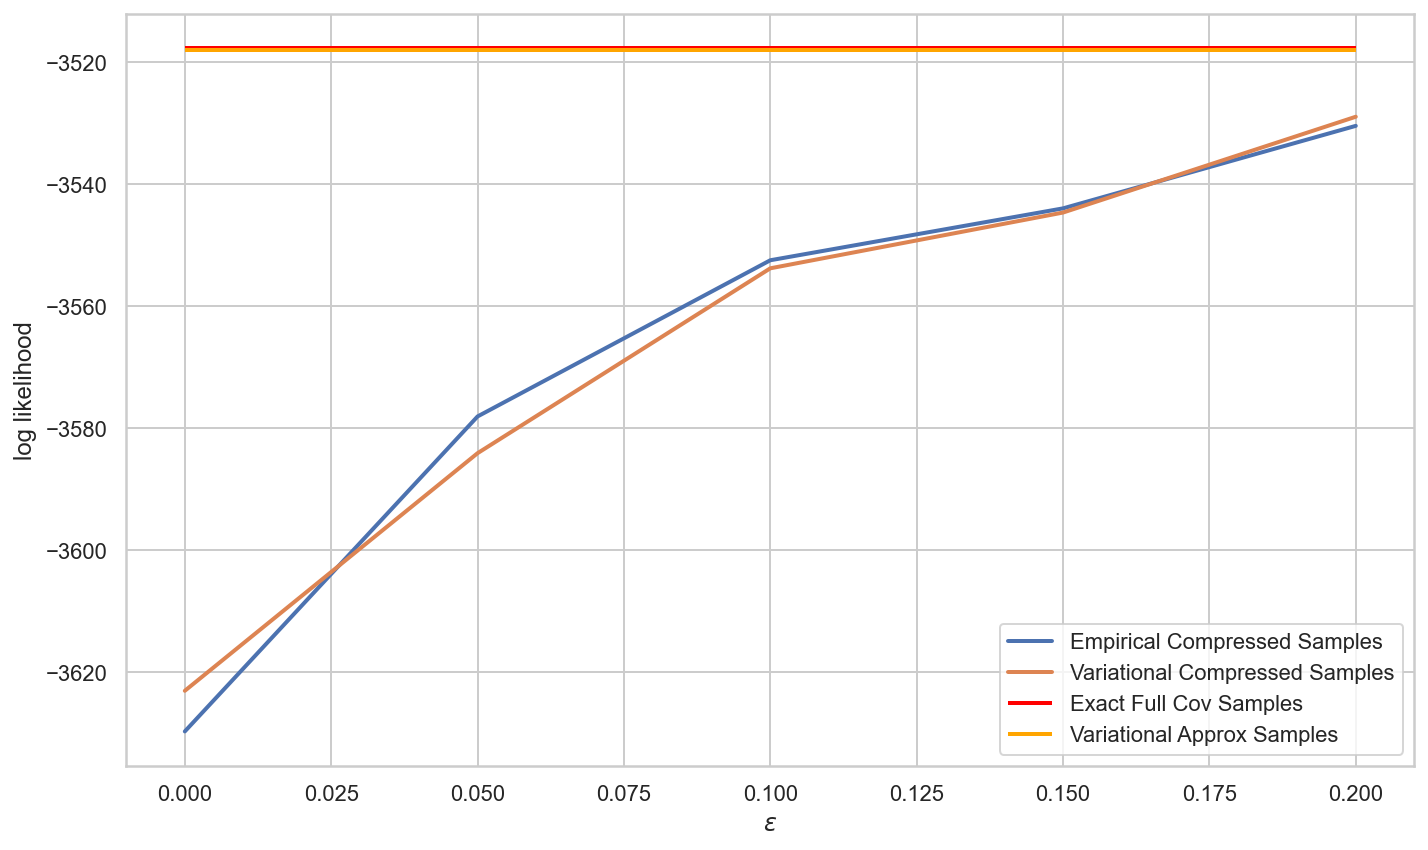

In [56]:
fig, ax = plt.subplots(1, figsize=(10,6))
ax.hlines(exact_ensemble_likelihood, xmin=epsilons[0], xmax=epsilons[-1], color='red', label='Exact Full Cov Samples')
ax.hlines(exact_ensemble_likelihood_var, xmin=epsilons[0], xmax=epsilons[-1], color='orange', label='Variational Approx Samples')
ax.plot(epsilons, emp_ensemble_log_likelihood, label='Empirical Compressed Samples')
ax.plot(epsilons, var_ensemble_log_likelihood, label='Variational Compressed Samples')
ax.set_xlabel(r'$\epsilon$')
ax.set_ylabel('log likelihood')
ax.legend(loc='lower right')
fig.tight_layout()
#fig.savefig(f"Figures/ENSEMBLE_LIKELIHOOD/Dim{dim}_Beamwidth{beamwidth}.jpg", dpi=250, bbox_inches='tight')